<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240806_podem01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Libraries

In [2]:
%%capture

# !pip install -U scikit-learn==0.24.2
# !pip install -U imbalanced-learn

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [3]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.3.2'

In [4]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [5]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac02.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1988 non-null   object        
 1   issuance_date     1988 non-null   datetime64[ns]
 2   issuance_year     1988 non-null   int64         
 3   issuance_week     1988 non-null   int64         
 4   monthfrac         1988 non-null   int64         
 5   eid_weeks         1988 non-null   int64         
 6   srbi_issuance     1988 non-null   int64         
 7   vix_indicator     1988 non-null   int64         
 8   bi_covid          1988 non-null   int64         
 9   gso_issuance      1988 non-null   int64         
 10  investment_grade  1988 non-null   int64         
 11  awarded_bid       1988 non-null   int64         
 12  way_perseri       1988 non-null   float64       
 13  bid_to_cover      1988 non-null   float64       
 14  srbi_way          1988 n

In [6]:
df_train00['issued_series'].value_counts()

issued_series
sun10    305
sun20    300
spn12    285
sun15    285
sun05    279
spn03    251
sun30    183
spn09     76
sun07     11
sun08     10
sun04      1
vr04       1
sun02      1
Name: count, dtype: int64

In [7]:
df_train00.describe()

,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,awarded_bid,way_perseri,bid_to_cover,srbi_way,srbi_size,incoming_bid
count,1988,1988.000000,1988.000000,1988.000000,1988.00000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1.988000e+03,1988.000000,1988.000000,1988.000000,1.988000e+03,1.988000e+03
mean,2017-11-26 16:07:43.581488896,2017.459759,24.286217,124.695674,0.07998,0.075453,0.078471,0.237425,0.021630,0.866700,2.550256e+06,0.063795,4.003104,0.004704,1.327404e+06,6.310364e+06
min,2009-01-13 00:00:00,2009.000000,1.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2014-03-14 12:00:00,2014.000000,12.000000,12.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,9.965000e+05,0.056596,1.455195,0.000000,0.000000e+00,2.421000e+06
50%,2018-09-12 00:00:00,2018.000000,24.000000,119.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.925000e+06,0.067974,2.137020,0.000000,0.000000e+00,4.420800e+06
75%,2021-08-06 18:00:00,2021.000000,36.000000,189.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,3.550000e+06,0.076005,3.339101,0.000000,0.000000e+00,8.030525e+06
max,2024-07-23 00:00:00,2024.000000,51.000000,367.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.465000e+07,0.139522,1000.500000,0.074732,4.490200e+07,4.516780e+07
std,NaN,4.416865,13.949296,108.833844,0.27133,0.264187,0.268979,0.425612,0.145508,0.339984,2.338466e+06,0.023158,24.662826,0.017454,5.688154e+06,5.916563e+06


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

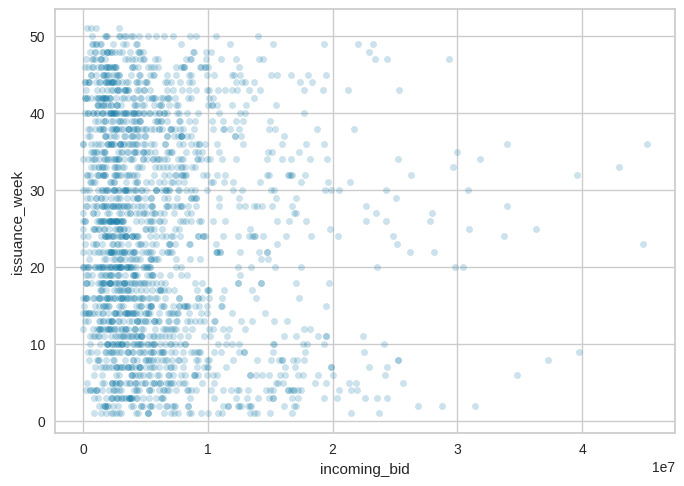

In [8]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

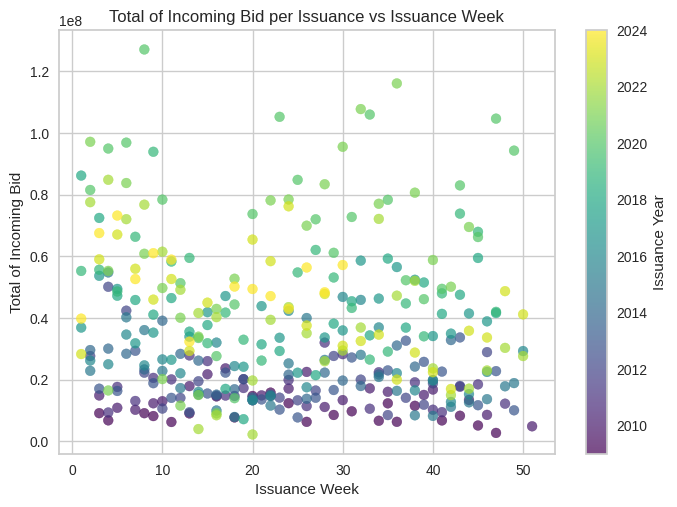

In [9]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

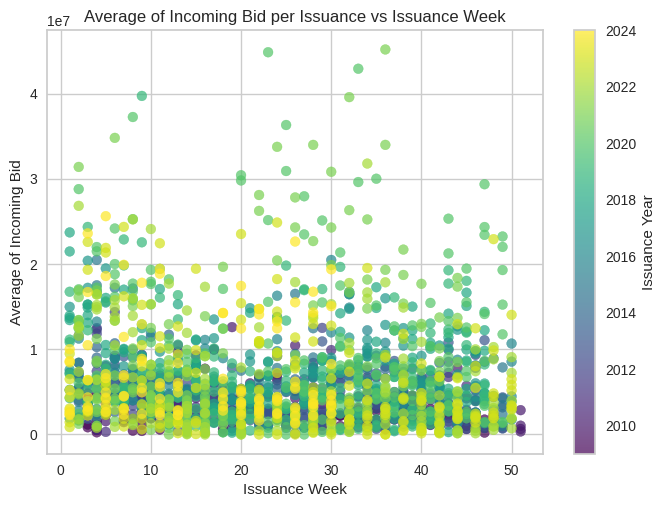

In [10]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [11]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

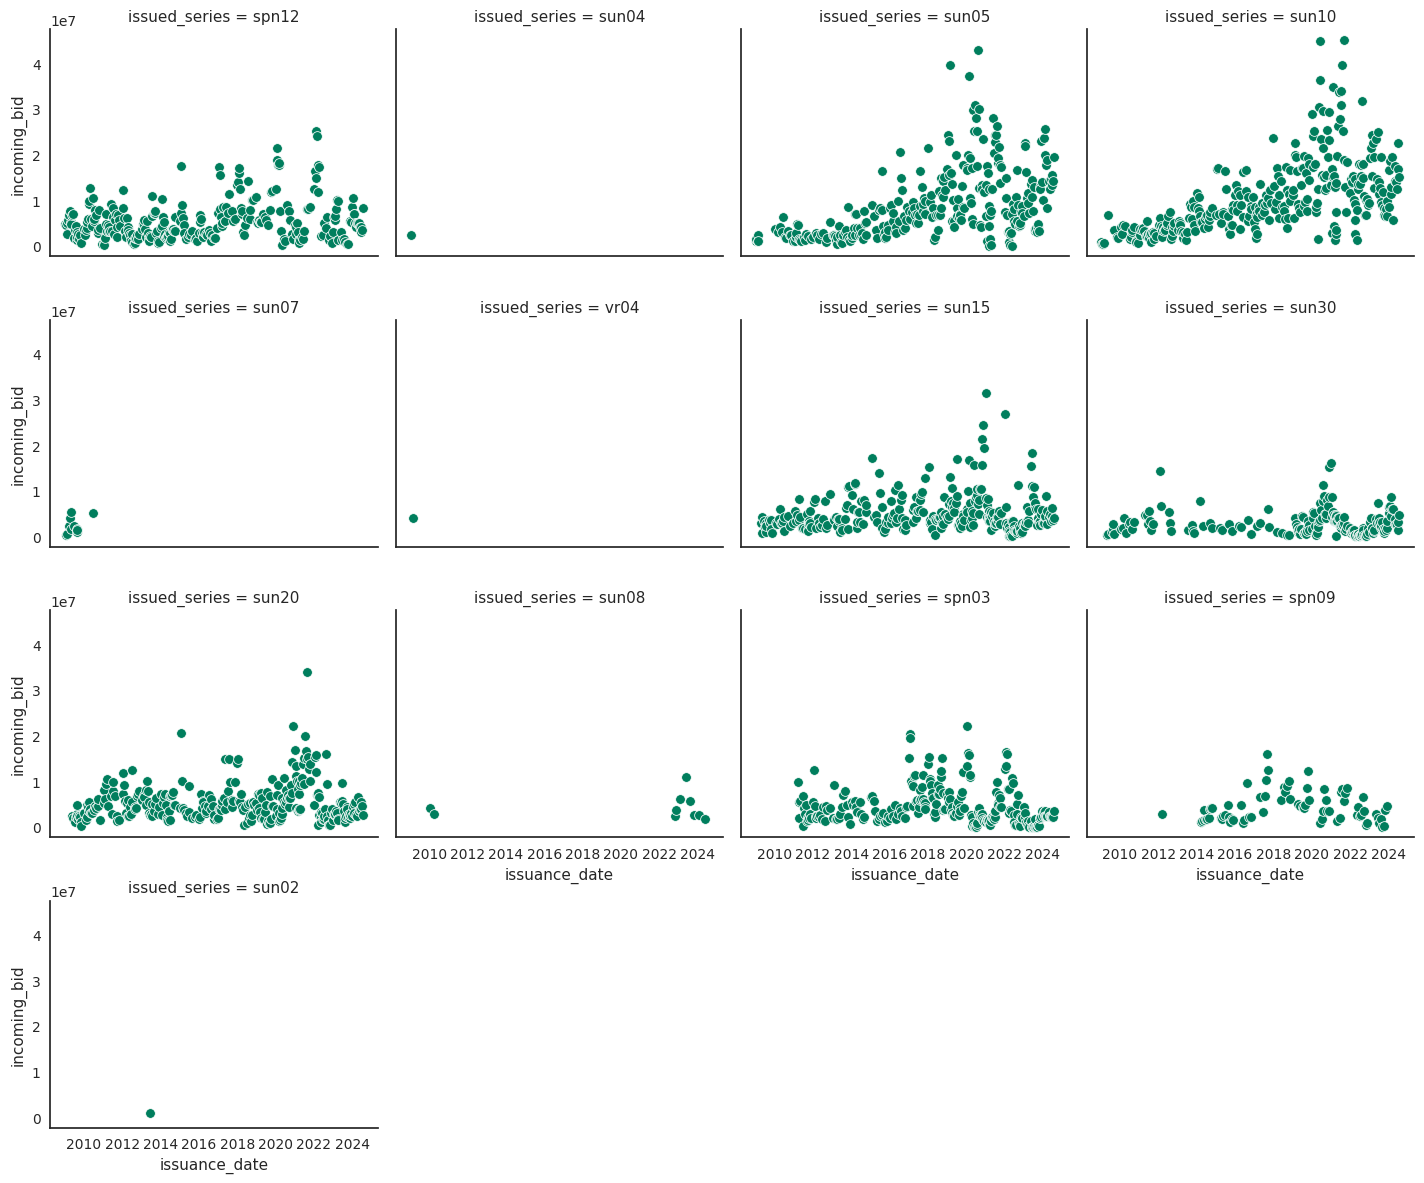

In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [13]:
# corr_matrix = df_train00.corr()
# corr_matrix['incoming_bid'].sort_values(ascending=False)

In [18]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

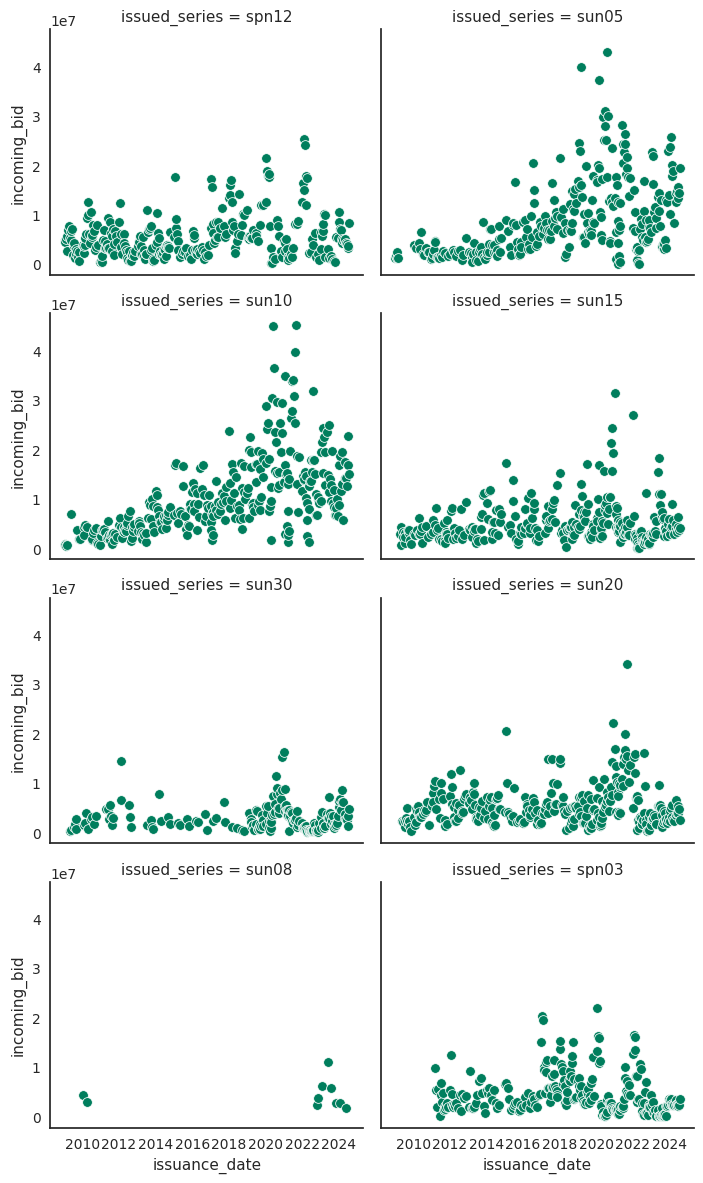

In [15]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [16]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

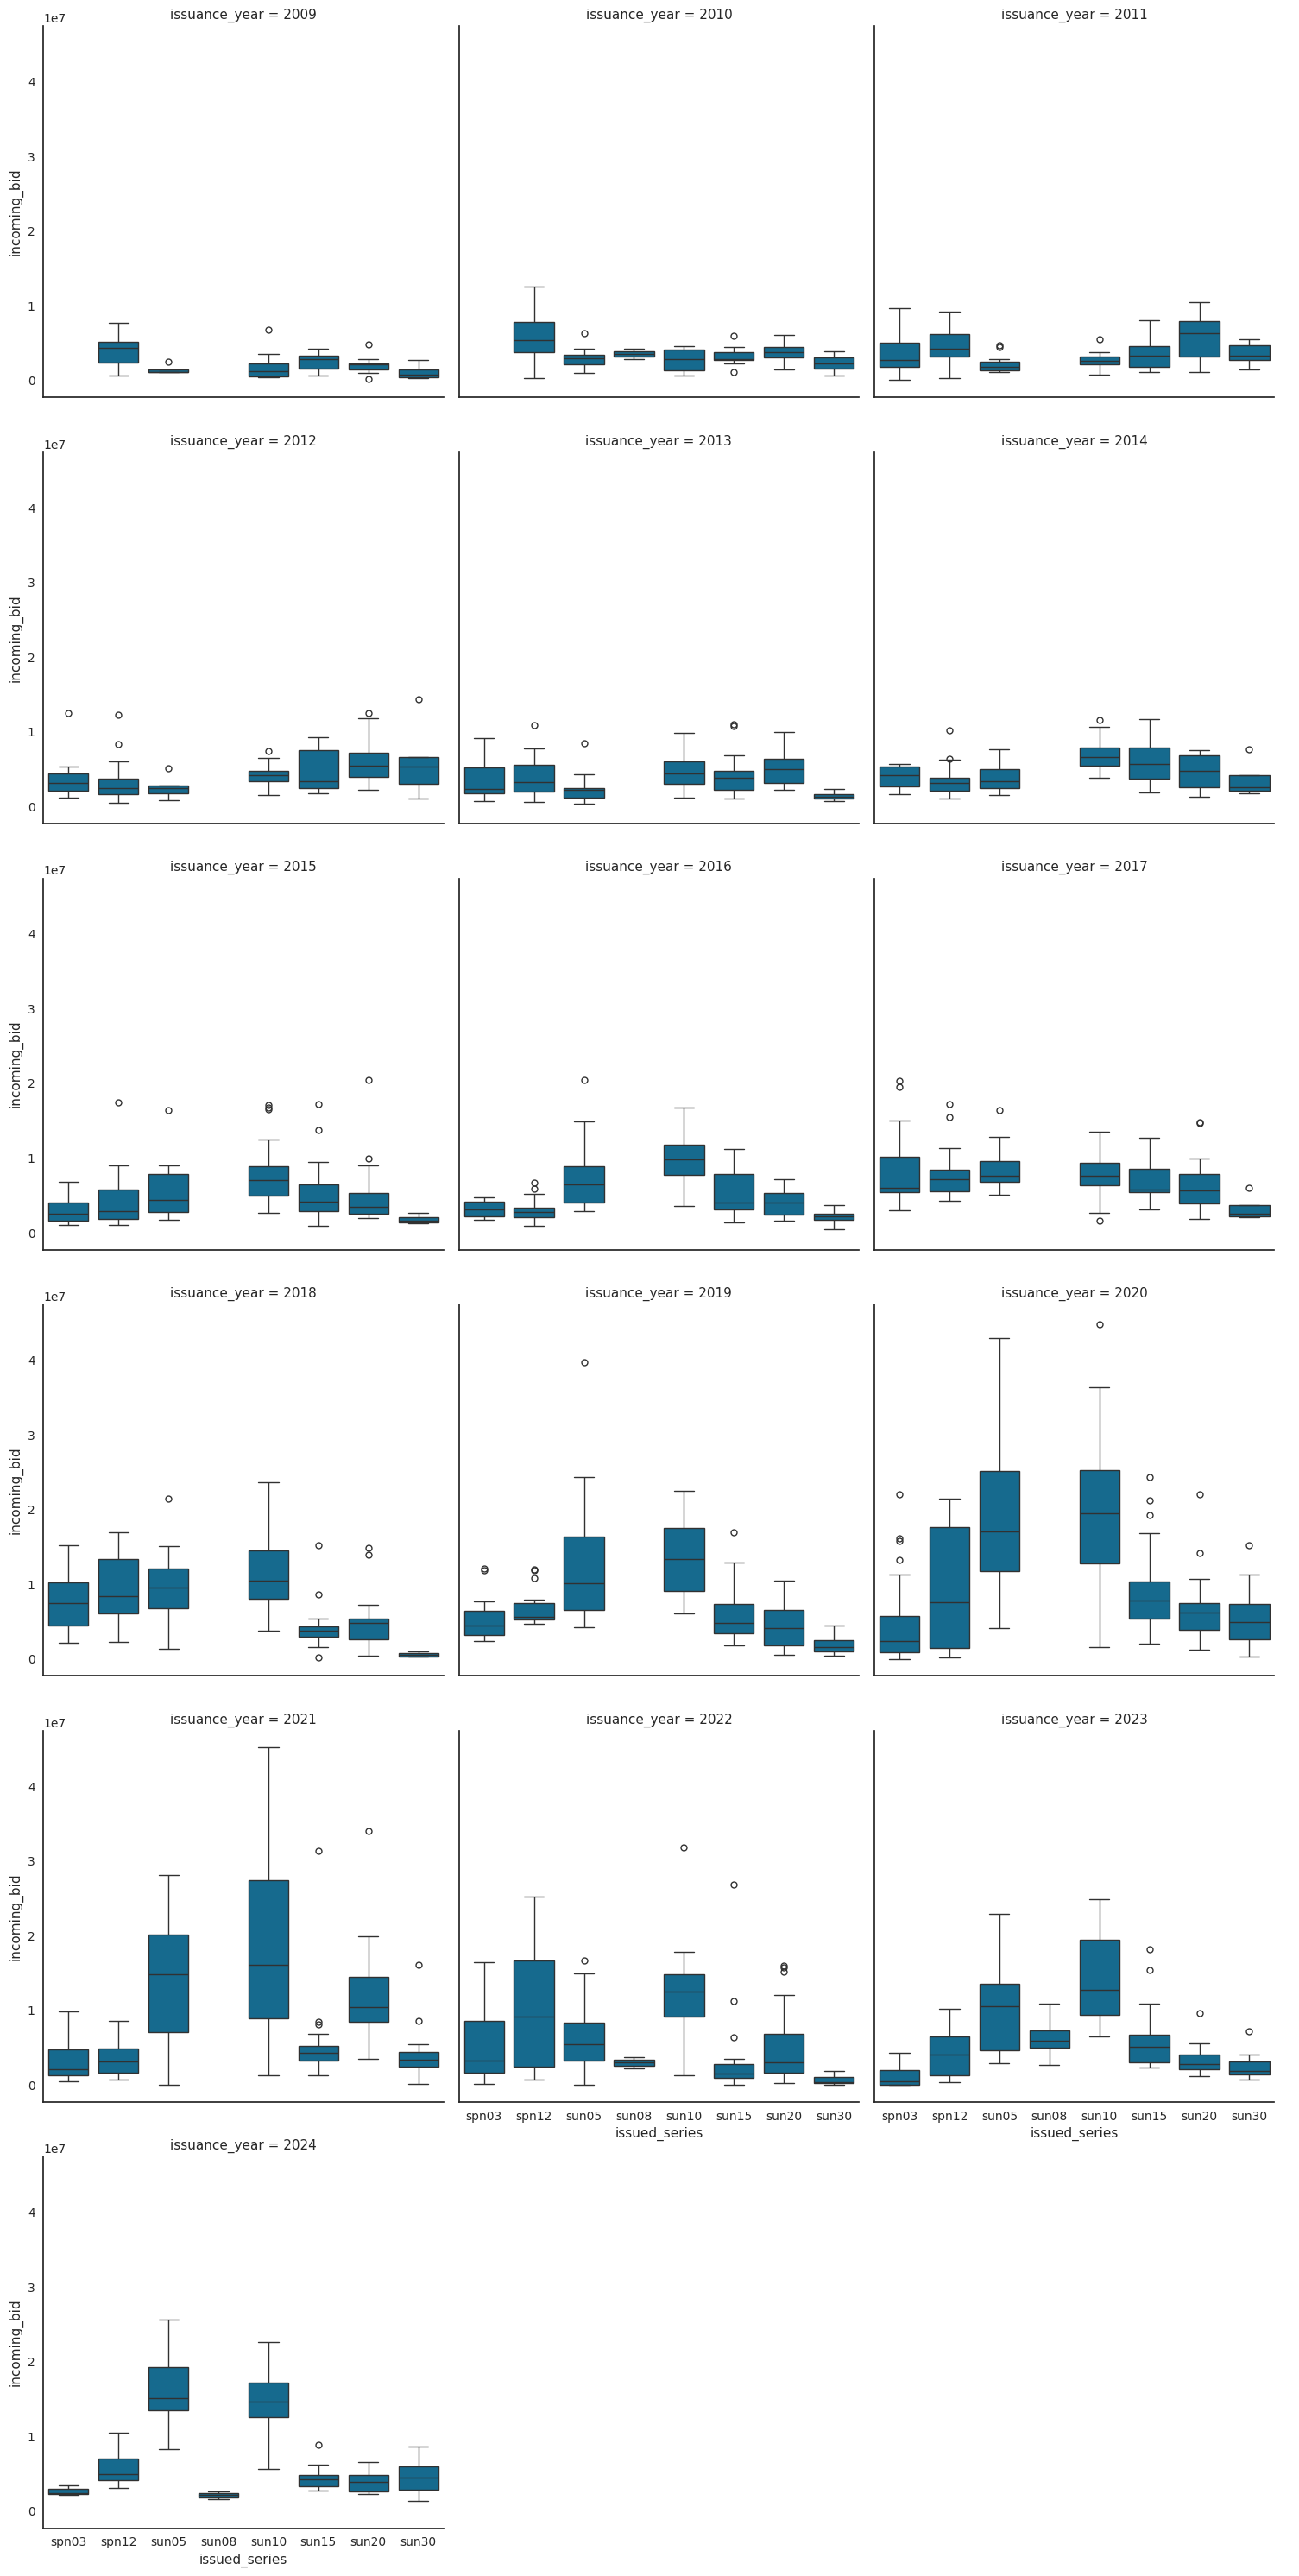

In [17]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [19]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [20]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1708, 17)
Test set shape: (190, 17)


In [22]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
issued_series
sun10    274
sun20    270
sun15    257
spn12    256
sun05    251
spn03    226
sun30    165
sun08      9
Name: count, dtype: int64 

Test: 
issued_series
sun10    31
sun20    30
spn12    29
sun05    28
sun15    28
spn03    25
sun30    18
sun08     1
Name: count, dtype: int64


In [23]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, awarded_bid, way_perseri, bid_to_cover, srbi_way, srbi_size, incoming_bid]
Index: []


In [24]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, awarded_bid, way_perseri, bid_to_cover, srbi_way, srbi_size, incoming_bid]
Index: []


# Methods

## Setup

In [25]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date', 'bid_to_cover', 'srbi_issuance'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1898, 17)"
4,Transformed data shape,"(1898, 21)"
5,Transformed train set shape,"(1708, 21)"
6,Transformed test set shape,"(190, 21)"
7,Ignore features,3
8,Numeric features,12
9,Categorical features,1


## Compare Models

In [26]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2146539.7756,11337683594781.4941,3335661.3952,0.6848,1.0316,0.6974,0.7300
et,Extra Trees Regressor,2169552.6550,11674362773787.0371,3388139.3673,0.6759,0.9254,0.6026,0.8330
xgboost,Extreme Gradient Boosting,2187705.4375,11972011465113.5996,3432357.2750,0.6677,1.0113,0.7137,0.1960
rf,Random Forest Regressor,2237187.9799,12144547879815.7715,3452406.0773,0.6641,1.0375,0.6892,0.8490
gbr,Gradient Boosting Regressor,2271250.0337,12339099018850.8594,3476281.9969,0.6582,1.0976,0.8339,0.2710
lasso,Lasso Regression,2602322.0127,15251339665605.2266,3867889.4155,0.5770,1.2672,1.3696,0.0820
lr,Linear Regression,2602650.9915,15252268948676.5820,3867984.2122,0.5770,1.2556,1.3697,0.5690
llar,Lasso Least Angle Regression,2601445.8896,15254344217760.1895,3868292.3756,0.5769,1.2569,1.3675,0.1010
ridge,Ridge Regression,2592881.5962,15285443996879.9160,3872497.4624,0.5760,1.2394,1.2689,0.0600
en,Elastic Net,2638928.1814,16189424564700.5957,3981378.6104,0.5537,1.2222,1.3236,0.0610


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2219148.1088,11556364536084.9590,3399465.3309,0.7079,2.1936,0.6035
1,2360295.6569,12626261533071.3008,3553345.1188,0.7103,0.5401,0.4427
2,1760568.6128,7475257133154.1377,2734091.6468,0.6332,0.8857,0.5850
3,1949794.2464,7671696130679.5762,2769782.6865,0.7746,1.2101,0.4845
4,2220838.0219,15363917411769.0117,3919683.3305,0.6696,0.5802,0.5903
5,2097467.5847,11622661226145.1406,3409202.4326,0.6327,0.6080,0.5945
6,1829491.5228,6745400624402.7402,2597190.9103,0.7744,1.2706,1.6221
7,2291088.5339,11009476749461.0938,3318053.1565,0.6854,0.6183,0.7664
8,2528459.2958,14723242792187.2090,3837087.8009,0.6529,1.1492,0.6402


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

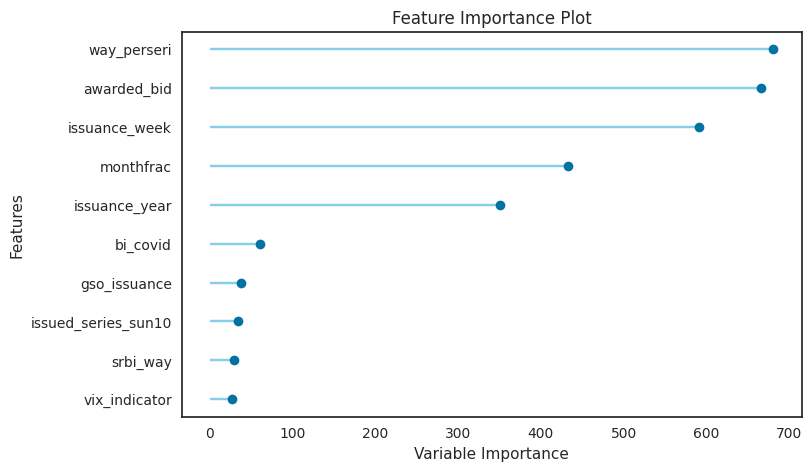

In [27]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2382353.5000,12477909696512.0000,3532408.5000,0.6846,2.2829,0.5679
1,2313668.5000,12478811471872.0000,3532536.0000,0.7137,0.5084,0.4206
2,1766858.5000,6874467401728.0000,2621920.5000,0.6627,1.0195,0.7168
3,2081366.6250,10518716743680.0000,3243257.0000,0.6910,1.1479,0.5083
4,2322325.2500,16659780730880.0000,4081639.5000,0.6418,0.6570,1.0558
5,2151745.0000,13482514710528.0000,3671854.5000,0.5740,0.5543,0.4839
6,1932764.5000,7695019540480.0000,2773989.7500,0.7427,1.1410,1.4933
7,2174452.7500,10810116014080.0000,3287874.0000,0.6911,0.5946,0.7137
8,2525910.5000,14870618570752.0000,3856244.0000,0.6495,1.0273,0.6496


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

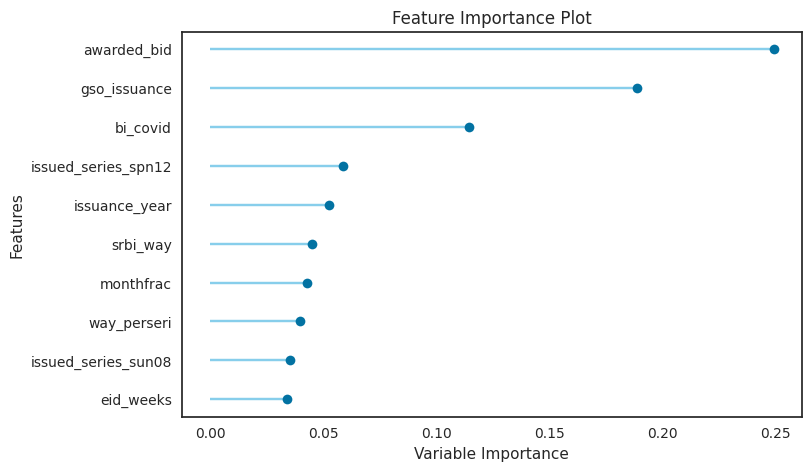

In [28]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2219256.4737,12576642193547.2227,3546356.1854,0.6821,2.2888,0.5452
1,2441663.8596,13703679290191.7773,3701848.0912,0.6856,0.5305,0.4671
2,1786387.3275,6572294956376.8125,2563648.7584,0.6775,1.0606,0.6855
3,1942465.1345,7610953128862.6787,2758795.5939,0.7764,0.5983,0.5065
4,2269539.4444,15866166262206.0859,3983235.6524,0.6588,0.6121,0.9081
5,2186575.2456,13184422382830.8477,3631035.9931,0.5834,0.5492,0.4836
6,1990285.3041,9311533072941.4805,3051480.4723,0.6886,0.9673,0.7051
7,2228616.7895,10474511846716.2168,3236435.0521,0.7007,0.5659,0.6009
8,2402945.8059,13681229927956.8066,3698814.6653,0.6775,1.1033,0.5706


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

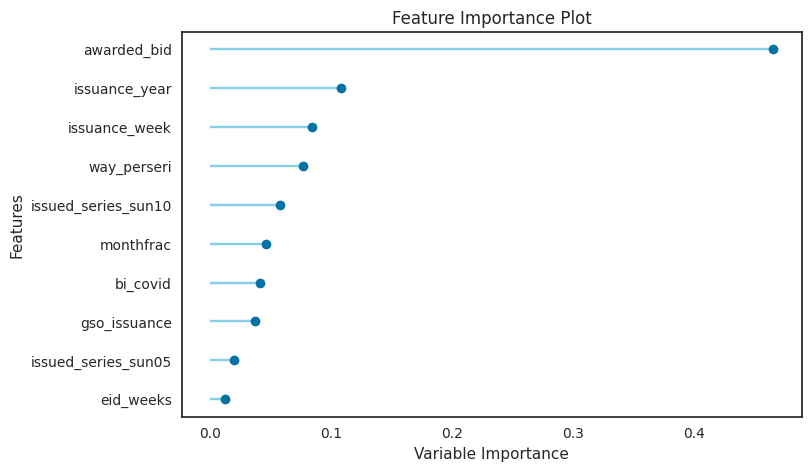

In [29]:
plot_model(create_model('et'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2245999.5380,12722674116819.2461,3566885.7729,0.6784,2.3891,0.5828
1,2519375.8947,14545477569787.3828,3813853.3755,0.6663,0.5596,0.5001
2,1830261.3977,7010742950871.0703,2647780.7596,0.6560,1.0340,0.6444
3,2060789.1988,8697966406948.3330,2949231.4943,0.7445,1.0233,0.6159
4,2260350.1988,16167735802146.0137,4020912.3097,0.6523,0.6638,1.2196
5,2209022.1696,13119683569141.5137,3622110.3751,0.5854,0.5828,0.5728
6,2005146.1520,7688905884056.4209,2772887.6436,0.7429,1.2161,0.9129
7,2388817.6374,11228108864457.8242,3350837.0394,0.6792,0.5915,0.6341
8,2536218.8412,15452433748950.5957,3930958.3754,0.6358,1.1648,0.5970


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

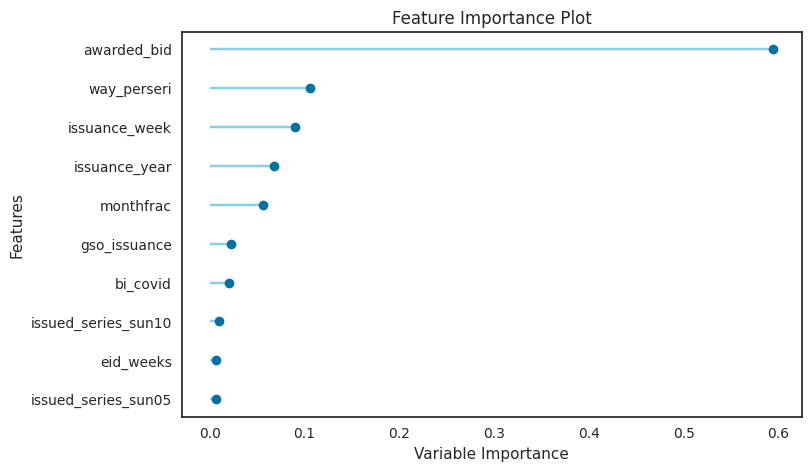

In [30]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 68.48%

In [31]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2219148.1088,11556364536084.9590,3399465.3309,0.7079,2.1936,0.6035
1,2360295.6569,12626261533071.3008,3553345.1188,0.7103,0.5401,0.4427
2,1760568.6128,7475257133154.1377,2734091.6468,0.6332,0.8857,0.5850
3,1949794.2464,7671696130679.5762,2769782.6865,0.7746,1.2101,0.4845
4,2220838.0219,15363917411769.0117,3919683.3305,0.6696,0.5802,0.5903
5,2097467.5847,11622661226145.1406,3409202.4326,0.6327,0.6080,0.5945
6,1829491.5228,6745400624402.7402,2597190.9103,0.7744,1.2706,1.6221
7,2291088.5339,11009476749461.0938,3318053.1565,0.6854,0.6183,0.7664
8,2528459.2958,14723242792187.2090,3837087.8009,0.6529,1.1492,0.6402


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 65.82%

In [32]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2443709.2287,12596487213250.9043,3549153.0276,0.6816,2.4733,0.7205
1,2456304.2443,12670576425488.2285,3559575.3153,0.7093,0.5778,0.5255
2,1748306.5046,6063962981896.6172,2462511.5191,0.7024,1.1863,0.6942
3,2144626.9269,9590251065164.1465,3096813.0498,0.7183,1.2826,0.7393
4,2472426.0550,15954872907969.0586,3994355.1304,0.6569,0.7711,1.8090
5,2319028.1763,12402016642779.4121,3521649.7047,0.6081,0.6162,0.6678
6,1976455.0807,8722017088572.0605,2953306.1285,0.7083,1.2529,2.2001
7,2510653.2337,13886220323248.9180,3726421.9197,0.6032,0.6498,0.6490
8,2645711.5918,15312844629724.0293,3913162.9955,0.6390,1.2725,0.6750


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 69.32%

In [33]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2344647.6524,11802140136063.6660,3435424.3022,0.7017,2.3345,0.6221
1,2344332.3686,11861152737804.5742,3444002.4300,0.7279,0.4891,0.4184
2,1720778.3260,6407023526935.9883,2531209.8939,0.6856,1.0460,0.7816
3,1945592.2436,8075702612023.5010,2841778.0723,0.7628,1.2423,0.5370
4,2273942.8710,14151279205918.2480,3761818.6035,0.6957,0.5967,0.6929
5,2141333.6332,11276314125203.7129,3358022.3533,0.6437,0.6270,0.5821
6,1948732.2874,6908757808507.2852,2628451.5990,0.7690,1.2857,1.5458
7,2318848.1696,11046034968188.1348,3323557.5771,0.6844,0.6569,1.0369
8,2542798.9862,14932202994893.2266,3864220.8781,0.6480,1.2467,0.6888


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


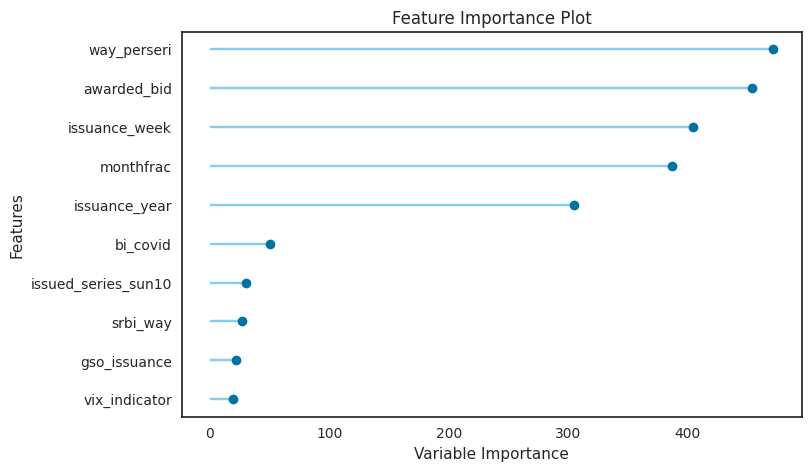

In [34]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 68.90%

In [35]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2204764.7257,11085020503405.8574,3329417.4420,0.7198,2.2251,0.5447
1,2318497.1821,11588545786858.5449,3404195.3215,0.7341,0.5347,0.4622
2,1670873.0129,6251284052970.8906,2500256.7974,0.6933,1.1344,0.6313
3,1920370.8062,7881607821958.1797,2807420.1363,0.7685,1.1813,0.4852
4,2291472.8563,15472128194325.1035,3933462.6214,0.6673,0.5195,0.4957
5,2202464.7440,12193628035100.5820,3491937.5761,0.6147,0.6009,0.6054
6,1822893.5034,6816288547579.9697,2610802.2804,0.7721,1.2260,1.5511
7,2273555.9369,11218571326443.8164,3349413.5795,0.6794,0.5987,0.7795
8,2483487.0474,14880761753974.7207,3857559.0409,0.6492,0.9427,0.5868


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 68.83%

In [36]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2265726.0330,11345076710636.5957,3368245.3460,0.7132,2.2037,0.6109
1,2410286.3366,12657872141047.4043,3557790.3453,0.7096,0.6018,0.5020
2,1793751.0073,6902720216481.2656,2627302.8406,0.6613,1.2237,0.6711
3,1977927.8888,8422333961225.9727,2902125.7659,0.7526,1.2307,0.5146
4,2213148.3213,14832689203289.9297,3851323.0458,0.6811,0.5930,0.5685
5,2128528.4463,11395315418685.3906,3375694.8053,0.6399,0.5655,0.6019
6,1891157.6691,6889589977377.2119,2624802.8454,0.7696,1.2397,1.5745
7,2235191.4301,11197136163915.1992,3346212.2114,0.6800,0.5825,0.6959
8,2497757.9779,13899777333048.3418,3728240.5144,0.6724,1.2443,0.6334


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 66.77%

In [37]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2382353.5000,12477909696512.0000,3532408.5000,0.6846,2.2829,0.5679
1,2313668.5000,12478811471872.0000,3532536.0000,0.7137,0.5084,0.4206
2,1766858.5000,6874467401728.0000,2621920.5000,0.6627,1.0195,0.7168
3,2081366.6250,10518716743680.0000,3243257.0000,0.6910,1.1479,0.5083
4,2322325.2500,16659780730880.0000,4081639.5000,0.6418,0.6570,1.0558
5,2151745.0000,13482514710528.0000,3671854.5000,0.5740,0.5543,0.4839
6,1932764.5000,7695019540480.0000,2773989.7500,0.7427,1.1410,1.4933
7,2174452.7500,10810116014080.0000,3287874.0000,0.6911,0.5946,0.7137
8,2525910.5000,14870618570752.0000,3856244.0000,0.6495,1.0273,0.6496


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 69.98%

In [38]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2235304.5000,11862158606336.0000,3444148.5000,0.7001,2.3452,0.5212
1,2266520.2500,11250875498496.0000,3354232.5000,0.7419,0.5631,0.4398
2,1757868.1250,6706175672320.0000,2589628.5000,0.6709,1.0888,0.6965
3,1974555.0000,7966889082880.0000,2822567.7500,0.7660,1.1845,0.4758
4,2110105.5000,13284085334016.0000,3644734.0000,0.7144,0.6043,0.8603
5,2123688.7500,10777145638912.0000,3282856.2500,0.6595,0.6409,0.5726
6,1911063.2500,6937897336832.0000,2633988.7500,0.7680,1.2735,1.4572
7,2147079.0000,10036352909312.0000,3168020.2500,0.7132,0.5558,0.4830
8,2581134.2500,15841427980288.0000,3980129.2500,0.6266,1.2395,0.6730


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 71.05%

In [39]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2244245.2500,11108285939712.0000,3332909.5000,0.7192,2.2611,0.5551
1,2283963.5000,12497716248576.0000,3535211.0000,0.7133,0.5165,0.4474
2,1641134.3750,6089134309376.0000,2467617.2500,0.7012,1.1375,0.6137
3,1908009.1250,7436853837824.0000,2727059.5000,0.7815,1.1972,0.5194
4,2110742.0000,14044713975808.0000,3747627.7500,0.6980,0.5881,0.8412
5,2063022.3750,10684658089984.0000,3268739.5000,0.6624,0.5598,0.5440
6,1802703.0000,7151026176000.0000,2674140.2500,0.7609,1.1003,1.9931
7,2163270.2500,9116418310144.0000,3019340.7500,0.7395,0.5562,0.6525
8,2368833.2500,13247121981440.0000,3639659.5000,0.6877,1.2593,0.6026


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


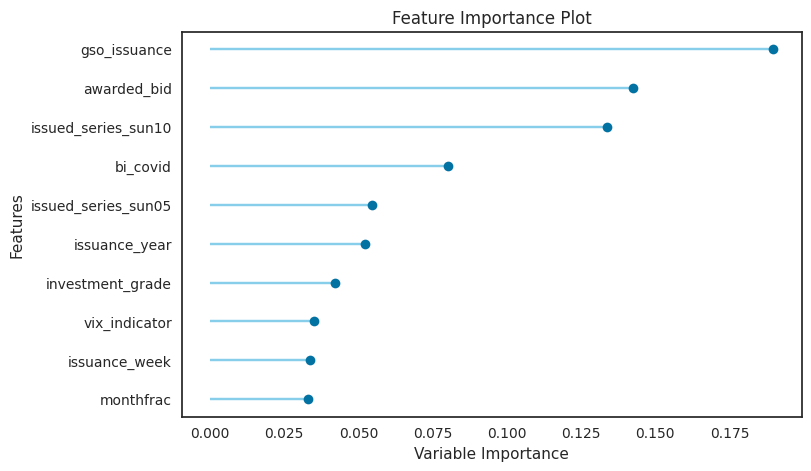

In [40]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 69.09%

In [41]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2266142.2500,12123271856128.0000,3481849.0000,0.6935,2.3956,0.5356
1,2328424.0000,12612581457920.0000,3551419.7500,0.7107,0.5177,0.4333
2,1660134.0000,5772220039168.0000,2402544.5000,0.7168,1.0676,0.7178
3,1987168.8750,8428033409024.0000,2903107.5000,0.7524,1.1680,0.5047
4,2089787.5000,14511528476672.0000,3809400.0000,0.6880,0.5811,0.8200
5,2168938.7500,12109766197248.0000,3479909.0000,0.6173,0.6110,0.5663
6,1841938.8750,6574821081088.0000,2564141.5000,0.7801,1.2305,2.2745
7,2182550.0000,10705862393856.0000,3271981.5000,0.6941,0.5473,0.5622
8,2485204.7500,15147734138880.0000,3892009.0000,0.6429,1.0656,0.5605


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 69.44%

In [42]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2200405.0000,10856214560768.0000,3294877.0000,0.7256,2.3363,0.5625
1,2336286.0000,12974117879808.0000,3601960.2500,0.7024,0.5295,0.4305
2,1705012.2500,6576651894784.0000,2564498.2500,0.6773,1.1232,0.6423
3,1915406.6250,7946940448768.0000,2819031.7500,0.7665,1.1811,0.5022
4,2092145.3750,14427184168960.0000,3798313.2500,0.6898,0.5953,0.9644
5,2105876.2500,11927590797312.0000,3453634.5000,0.6231,0.6120,0.5289
6,1846525.3750,6857163276288.0000,2618618.5000,0.7707,1.2130,1.8284
7,2239187.7500,10574749499392.0000,3251884.0000,0.6978,0.5352,0.5305
8,2424771.5000,14167830429696.0000,3764017.7500,0.6660,1.0224,0.6136


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

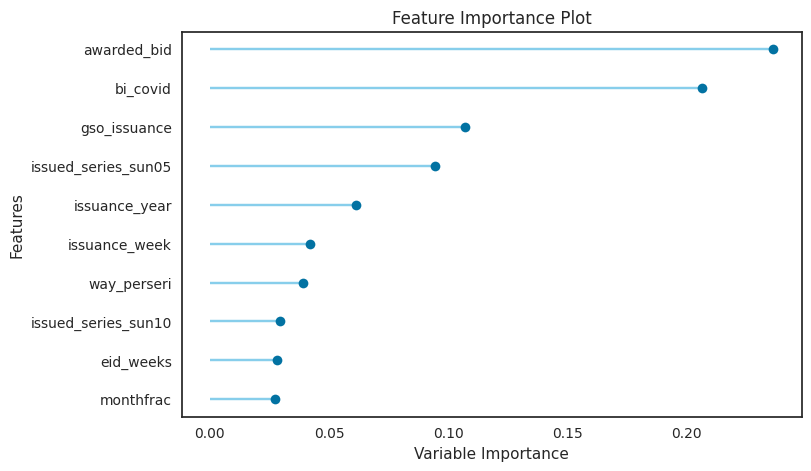

In [43]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 67.59%

In [44]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2219256.4737,12576642193547.2227,3546356.1854,0.6821,2.2888,0.5452
1,2441663.8596,13703679290191.7773,3701848.0912,0.6856,0.5305,0.4671
2,1786387.3275,6572294956376.8125,2563648.7584,0.6775,1.0606,0.6855
3,1942465.1345,7610953128862.6787,2758795.5939,0.7764,0.5983,0.5065
4,2269539.4444,15866166262206.0859,3983235.6524,0.6588,0.6121,0.9081
5,2186575.2456,13184422382830.8477,3631035.9931,0.5834,0.5492,0.4836
6,1990285.3041,9311533072941.4805,3051480.4723,0.6886,0.9673,0.7051
7,2228616.7895,10474511846716.2168,3236435.0521,0.7007,0.5659,0.6009
8,2402945.8059,13681229927956.8066,3698814.6653,0.6775,1.1033,0.5706


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 64.71%

In [45]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2326619.8749,12648291214576.2598,3556443.6189,0.6803,2.4774,0.6180
1,2453608.2203,13353968941666.9043,3654308.2713,0.6936,0.5619,0.5570
2,1879307.1062,6974363124255.8652,2640901.9528,0.6578,1.2179,0.7610
3,2146358.0985,9185555904755.9727,3030768.2037,0.7302,1.2041,0.6724
4,2401836.2759,16386472326308.1699,4048020.7912,0.6476,0.6755,1.2155
5,2345313.1905,13761991119235.6641,3709715.7734,0.5651,0.6128,0.6709
6,1957884.4523,7376171190200.8623,2715910.7478,0.7533,1.3008,1.8521
7,2576745.2195,13462127442037.5664,3669077.1922,0.6153,0.6559,0.8094
8,2618355.6714,16089661877308.0059,4011192.0768,0.6207,1.2148,0.6347


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 68.53%

In [46]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2341016.7671,12829035576334.7305,3581764.3106,0.6757,2.4666,0.6836
1,2226638.1442,12415749841320.4434,3523598.9899,0.7152,0.5145,0.5142
2,1875110.1196,6754755130149.6055,2598991.1755,0.6686,1.1915,0.9569
3,2056679.1061,8365832474665.4717,2892374.8849,0.7542,1.1662,0.6789
4,2200544.5790,14790449144493.7480,3845835.2987,0.6820,0.6705,1.7500
5,2118093.1858,11749444712531.5469,3427746.3022,0.6287,0.5738,0.6206
6,1902262.8561,6741572940271.5938,2596453.9165,0.7746,1.2831,1.3164
7,2233301.7881,10958250310156.9785,3310324.8043,0.6869,0.6285,0.8835
8,2407881.4575,14714182312882.6055,3835906.9740,0.6532,1.2520,0.7399


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Bagging -- 68.38%

In [47]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2193896.3310,12166345318885.8887,3488028.8587,0.6924,2.3787,0.5447
1,2402501.0368,13000729224566.1250,3605652.3993,0.7018,0.5251,0.4870
2,1771548.1386,6368243126260.2119,2523537.8195,0.6875,1.0609,0.6973
3,1954483.4795,7700563555825.3184,2774988.9290,0.7738,0.9531,0.5287
4,2237999.7749,15508015811910.3301,3938021.8146,0.6665,0.6120,0.9992
5,2201638.8158,12480164147190.2129,3532727.5790,0.6056,0.5787,0.5916
6,1926541.4485,7841429177219.9932,2800255.1986,0.7378,1.2073,0.7205
7,2322051.5140,10776281309376.8340,3282724.6777,0.6921,0.6019,0.6807
8,2456072.5724,13913169553107.5820,3730036.1329,0.6720,1.1496,0.5803


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 69.01%

In [48]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2176081.0702,11657490348605.8184,3414306.7157,0.7053,2.3230,0.5669
1,2334918.4444,12041482806854.8066,3470083.9769,0.7238,0.5069,0.4867
2,1768410.0351,6330355505117.7197,2516019.7744,0.6894,1.1170,0.6967
3,1949568.1988,7294367727044.1875,2700808.7172,0.7857,1.0039,0.5520
4,2277037.7018,16184628567469.9355,4023012.3748,0.6520,0.6286,1.1529
5,2136298.6199,11982769990616.3867,3461613.7841,0.6214,0.5271,0.5086
6,1965024.9825,8501066154172.9932,2915658.7856,0.7157,1.0369,0.7444
7,2291145.3801,10575671347143.5664,3252025.7298,0.6978,0.6212,0.7523
8,2419440.3882,13477592101361.5410,3671184.0190,0.6823,1.1574,0.6002


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

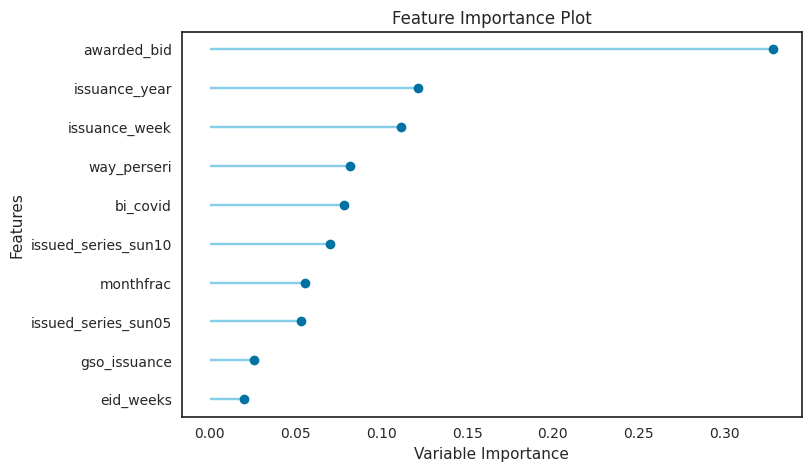

In [49]:
plot_model(et_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 66.41%

In [50]:
# train a rf model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2245999.5380,12722674116819.2461,3566885.7729,0.6784,2.3891,0.5828
1,2519375.8947,14545477569787.3828,3813853.3755,0.6663,0.5596,0.5001
2,1830261.3977,7010742950871.0703,2647780.7596,0.6560,1.0340,0.6444
3,2060789.1988,8697966406948.3330,2949231.4943,0.7445,1.0233,0.6159
4,2260350.1988,16167735802146.0137,4020912.3097,0.6523,0.6638,1.2196
5,2209022.1696,13119683569141.5137,3622110.3751,0.5854,0.5828,0.5728
6,2005146.1520,7688905884056.4209,2772887.6436,0.7429,1.2161,0.9129
7,2388817.6374,11228108864457.8242,3350837.0394,0.6792,0.5915,0.6341
8,2536218.8412,15452433748950.5957,3930958.3754,0.6358,1.1648,0.5970


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 66.40%

In [51]:
# tune hyperparameters of rf
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2293398.3820,12340754016971.0117,3512940.9356,0.6880,2.5219,0.6995
1,2458159.8256,14111218662753.0781,3756490.2053,0.6763,0.5691,0.5959
2,1838638.5846,6446755882657.2158,2539046.2545,0.6837,1.2489,0.9483
3,2089168.7807,8794776544963.4561,2965598.8510,0.7416,1.2382,0.7198
4,2430154.3308,16056534934588.0488,4007060.6353,0.6547,0.7050,1.7973
5,2210941.9406,12590493496381.0605,3548308.5402,0.6022,0.5989,0.6792
6,1950665.3125,6665315069220.1084,2581727.1485,0.7771,1.3279,2.0064
7,2475455.1180,12976068847145.8965,3602231.0930,0.6292,0.6503,0.8980
8,2525549.3983,15934033842368.7324,3991745.7136,0.6244,1.2547,0.7414


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 69.76%

In [52]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2134402.4795,11709558807727.2715,3421923.2615,0.7040,2.4279,0.5876
1,2281683.8480,12151468697426.1465,3485895.6808,0.7212,0.5107,0.4940
2,1687719.3907,5765243740675.0068,2401092.1975,0.7171,1.1680,0.7605
3,1882050.3859,7478166525265.7852,2734623.6533,0.7803,1.1583,0.5559
4,2249604.7289,15271919331628.2871,3907930.3130,0.6716,0.6507,1.3974
5,2052126.0533,11906834762132.2559,3450628.1692,0.6238,0.5491,0.5663
6,1805823.3492,6228419145044.3701,2495680.0967,0.7917,1.2269,1.1058
7,2304430.5533,11288779233189.3242,3359877.8599,0.6774,0.5970,0.7538
8,2355116.7629,14124855795375.9707,3758304.9098,0.6671,1.2031,0.6233


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Bagging -- 66.56%

In [53]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2346971.6064,13207409440695.8867,3634199.9726,0.6661,2.4414,0.5909
1,2475313.6415,13538051601468.5957,3679409.1375,0.6894,0.5505,0.5173
2,1802686.7181,6274129371967.1123,2504821.2256,0.6921,1.1343,0.6884
3,2089001.2456,8513558432769.3389,2917800.2729,0.7499,1.1300,0.5958
4,2324822.5485,15937967733131.7930,3992238.4364,0.6573,0.6467,1.1488
5,2267644.1661,13148525562005.1133,3626089.5689,0.5845,0.6115,0.6297
6,2005686.7971,7393156000926.6318,2719035.8587,0.7528,1.2469,1.0732
7,2396372.3661,11265576079727.9746,3356423.1080,0.6781,0.6168,0.6914
8,2538804.9018,15966758585114.9668,3995842.6627,0.6236,1.1858,0.5980


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.95%

In [54]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2295033.4737,11595831043162.9004,3405265.1942,0.7069,2.4232,0.6462
1,2525205.1754,13556300523594.3223,3681888.1737,0.6890,0.5554,0.5498
2,1877964.7251,7322660703250.3154,2706041.5191,0.6407,1.1435,0.7018
3,2153144.7076,8765366356616.2051,2960636.1405,0.7425,1.1530,0.6426
4,2333816.4912,16305312456768.2461,4037983.7118,0.6494,0.6693,1.2874
5,2269458.9474,13315833729907.2637,3649086.6981,0.5792,0.5870,0.6043
6,1951159.3333,6823401093811.3916,2612164.0633,0.7718,1.2230,1.3356
7,2471337.9474,12045161203353.9941,3470613.9519,0.6558,0.6239,0.7419
8,2527912.2059,14796139963236.8184,3846575.0952,0.6512,1.1996,0.6196


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

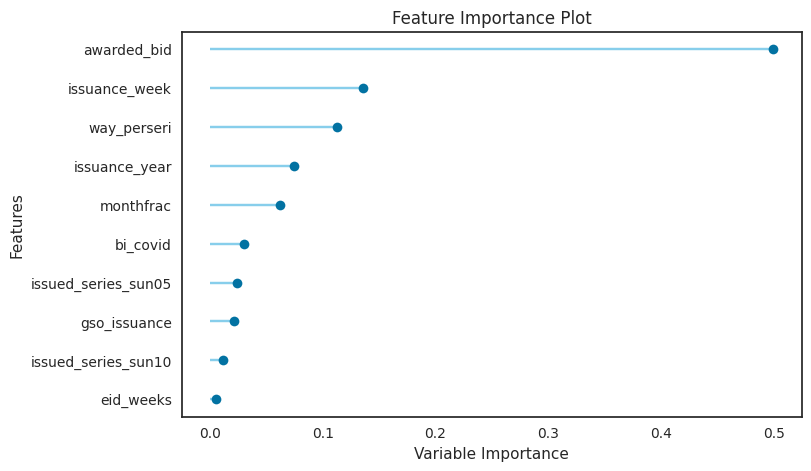

In [55]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 71.87%

In [56]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_modified, et_boosted, rf_modified], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2110803.7731,10650154051810.4531,3263457.3770,0.7308,2.2517,0.5276
1,2221117.2647,11414468062119.1465,3378530.4590,0.7381,0.4722,0.4284
2,1627950.8998,5661179716418.3086,2379323.3737,0.7222,1.0324,0.6891
3,1817178.4730,6822499769571.3184,2611991.5332,0.7996,1.1360,0.4711
4,2107377.0824,14117967526681.9160,3757388.3918,0.6964,0.5934,0.9120
5,2001656.7580,10813752761747.1270,3288427.0954,0.6583,0.5385,0.5228
6,1778210.8584,6307926723586.3848,2511558.6244,0.7891,1.1944,1.3115
7,2185305.3468,9869053868982.8711,3141505.0325,0.7180,0.5470,0.5997
8,2350901.5856,13370197527602.2852,3656528.0701,0.6848,1.0729,0.6047


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [57]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2005264.5889,8208135743594.0908,2864984.4229,0.7517,0.4545,0.4150


In [ ]:
# plot_model(blended, plot = 'residuals')

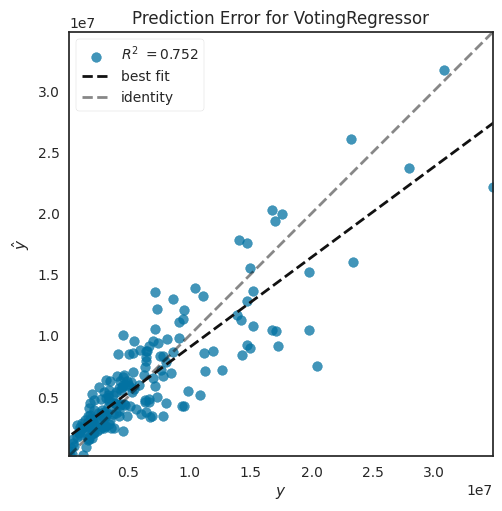

In [58]:
plot_model(blended, plot = 'error')

## Stacked -- 71.50%

In [59]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_modified, et_boosted, rf_modified])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2082097.2095,10500228977905.3809,3240405.6811,0.7346,2.0441,0.4954
1,2205754.7259,11323939190317.2305,3365106.1187,0.7402,0.4529,0.3880
2,1596690.7891,5694992491080.2744,2386418.3395,0.7206,1.0832,0.6253
3,1788316.1191,6994200344952.9092,2644655.0522,0.7945,1.1252,0.4287
4,2120851.6275,14131397124505.4688,3759175.0590,0.6961,0.6034,0.7311
5,1974123.8579,10885990206432.7520,3299392.3996,0.6560,0.5683,0.4770
6,1762917.5938,6603992815156.1025,2569823.4988,0.7792,1.1395,0.9428
7,2195146.9327,10323302109047.7773,3212989.5906,0.7050,0.5642,0.6627
8,2355583.4889,13483679267741.4727,3672012.9722,0.6822,1.0854,0.5867


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [60]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2007222.6385,8203223626042.0127,2864127.0269,0.7519,0.5779,0.3998


In [ ]:
# plot_model(stacked, plot = 'residuals')

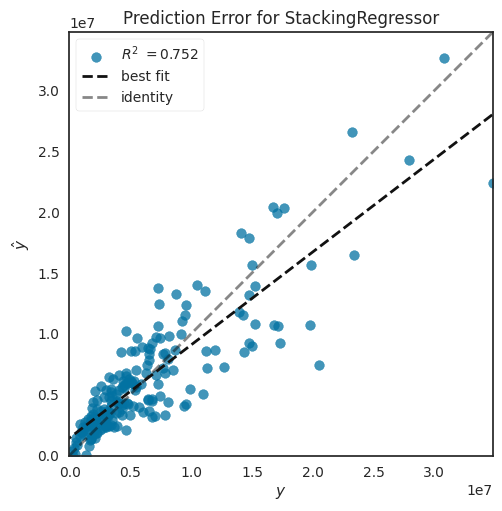

In [61]:
plot_model(stacked, plot = 'error')

## Finalizing -- 97.39% & 96.87%

In [62]:
final = finalize_model(stacked)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,671503.3261,863329642606.6213,929155.3383,0.9739,0.2629,0.1476


In [63]:
final02 = finalize_model(blended)
predict_model(final02);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,729684.7269,1033807466954.4158,1016763.2305,0.9687,0.1988,0.1640


In [64]:
save_model(final, '/content/drive/MyDrive/00database/20240806_stacked01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'vix_indicator', 'bi_covid',
                                              'gso_issuance', 'investment_grade',
                                              'awarded_bid', 'way_perseri',
                                              'srbi_way', 'srbi_size'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issue...
                                                ('Extra Trees Regressor',
                                                 AdaBoostRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                                                 random_state=123),
 

In [65]:
save_model(final02, '/content/drive/MyDrive/00database/20240806_blended01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'vix_indicator', 'bi_covid',
                                              'gso_issuance', 'investment_grade',
                                              'awarded_bid', 'way_perseri',
                                              'srbi_way', 'srbi_size'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issue...
                                                            num_parallel_tree=None,
                                                            random_state=123, ...)),
                                              ('Extra Trees Regressor',
                                               AdaBoostReg

# Lelang 6 Aug 2024

## Load

In [66]:
lelang20240806 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac02.xlsx', sheet_name='lelang20240806')
lelang20240806['issuance_date'] = pd.to_datetime(lelang20240806['issuance_date'], format='%Y-%m-%d')
lelang20240806.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     8 non-null      object        
 1   issuance_date     8 non-null      datetime64[ns]
 2   issuance_year     8 non-null      int64         
 3   issuance_week     8 non-null      int64         
 4   monthfrac         8 non-null      int64         
 5   eid_weeks         8 non-null      int64         
 6   srbi_issuance     8 non-null      int64         
 7   vix_indicator     8 non-null      int64         
 8   bi_covid          8 non-null      int64         
 9   gso_issuance      8 non-null      int64         
 10  investment_grade  8 non-null      int64         
 11  awarded_bid       8 non-null      int64         
 12  way_perseri       8 non-null      float64       
 13  bid_to_cover      8 non-null      float64       
 14  srbi_way          8 non-null  

## Predict: Stacked

In [67]:
# load model
stacked01_20240806 = load_model("/content/drive/MyDrive/00database/20240806_stacked01")

# predict model on new_data
predict03= predict_model(stacked01_20240806, data = lelang20240806)
predict03

# predict model on new_data
# predict03= predict_model(final, data = lelang20240625)
# predict03

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,awarded_bid,way_perseri,bid_to_cover,srbi_way,srbi_size,prediction_label
0,spn03,2024-08-06,2024,32,3,0,1,0,0,0,1,587500,0.048714,3.269928,0.07228,35102000,2.463485e+06
1,spn12,2024-08-06,2024,32,12,0,1,0,0,0,1,450000,0.050650,9.602500,0.07228,35102000,4.320296e+06
2,sun05,2024-08-06,2024,32,56,0,1,0,0,0,1,7175000,0.069154,2.401750,0.07228,35102000,1.682679e+07
3,sun08,2024-08-06,2024,32,74,0,1,0,0,0,1,900000,0.068438,4.014768,0.07228,35102000,3.830007e+06
4,sun10,2024-08-06,2024,32,114,0,1,0,0,0,1,9762500,0.070366,1.792178,0.07228,35102000,1.747743e+07
5,sun15,2024-08-06,2024,32,166,0,1,0,0,0,1,1937500,0.071273,2.406683,0.07228,35102000,4.044468e+06
6,sun20,2024-08-06,2024,32,226,0,1,0,0,0,1,1887500,0.071434,5.674595,0.07228,35102000,3.502133e+06
7,sun30,2024-08-06,2024,32,359,0,1,0,0,0,1,950000,0.071394,5.966544,0.07228,35102000,2.865538e+06


In [68]:
# @title Lelang 20240806: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-08-06    |      2.46 trillion |
| spn12           |   2024-08-06    |      4.32 trillion |
| sun05           |   2024-08-06    |     16.83 trillion |
| sun08           |   2024-08-06    |      3.83 trillion |
| sun10           |   2024-08-06    |     17.48 trillion |
| sun15           |   2024-08-06    |      4.04 trillion |
| sun20           |   2024-08-06    |      3.50 trillion |
| sun30           |   2024-08-06    |      2.87 trillion |


In [69]:
# @title Lelang 20240806: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a stacked machine learning algorithm model with an R-squared value of 71.50%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a stacked machine learning algorithm model with an R-squared value of 71.50%,
the estimated incoming bid for the next issuance is approximately Rp55,330,148.23 million
or Rp55.33 trillion.



## Predict: Blended

In [70]:
# load model
blended01_20240806 = load_model("/content/drive/MyDrive/00database/20240806_blended01")

# predict model on new_data
predict05 = predict_model(blended01_20240806, data = lelang20240806)
predict05

# predict model on new_data
# predict04= predict_model(final, data = lelang20240625)
# predict04

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,awarded_bid,way_perseri,bid_to_cover,srbi_way,srbi_size,prediction_label
0,spn03,2024-08-06,2024,32,3,0,1,0,0,0,1,587500,0.048714,3.269928,0.07228,35102000,2.628850e+06
1,spn12,2024-08-06,2024,32,12,0,1,0,0,0,1,450000,0.050650,9.602500,0.07228,35102000,4.466262e+06
2,sun05,2024-08-06,2024,32,56,0,1,0,0,0,1,7175000,0.069154,2.401750,0.07228,35102000,1.646870e+07
3,sun08,2024-08-06,2024,32,74,0,1,0,0,0,1,900000,0.068438,4.014768,0.07228,35102000,3.937171e+06
4,sun10,2024-08-06,2024,32,114,0,1,0,0,0,1,9762500,0.070366,1.792178,0.07228,35102000,1.712490e+07
5,sun15,2024-08-06,2024,32,166,0,1,0,0,0,1,1937500,0.071273,2.406683,0.07228,35102000,4.164832e+06
6,sun20,2024-08-06,2024,32,226,0,1,0,0,0,1,1887500,0.071434,5.674595,0.07228,35102000,3.643440e+06
7,sun30,2024-08-06,2024,32,359,0,1,0,0,0,1,950000,0.071394,5.966544,0.07228,35102000,3.000974e+06


In [71]:
# @title Lelang 20240806: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict06 = predict05[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict06['issuance_date'] = predict06['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict06['prediction_label'] = predict06['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict06.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-08-06    |      2.63 trillion |
| spn12           |   2024-08-06    |      4.47 trillion |
| sun05           |   2024-08-06    |     16.47 trillion |
| sun08           |   2024-08-06    |      3.94 trillion |
| sun10           |   2024-08-06    |     17.12 trillion |
| sun15           |   2024-08-06    |      4.16 trillion |
| sun20           |   2024-08-06    |      3.64 trillion |
| sun30           |   2024-08-06    |      3.00 trillion |


In [73]:
# @title Lelang 20240806: Total

# Sum total incoming bid
incoming_bid02 = predict05['prediction_label'].sum()

# Round to two decimal places
rounded_bid02 = round(incoming_bid02, 2)
formatted_rounded_bid02 = 'Rp{:,.2f} million'.format(rounded_bid02)

# Adjust to the nearest thousand
formatted_incoming_bid02 = 'Rp{:,.2f} trillion'.format(rounded_bid02 / 1000000)

output_message02 = f"""
According to a stacked machine learning algorithm model with an R-squared value of 71.87%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid02}
or {formatted_incoming_bid02}.
"""

print(output_message02)



According to a stacked machine learning algorithm model with an R-squared value of 71.87%,
the estimated incoming bid for the next issuance is approximately Rp55,435,126.00 million
or Rp55.44 trillion.

